In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from tree import Tree

np.seterr(all="ignore")
if not hasattr(np, 'alltrue'):
    np.alltrue = np.all

In [2]:
NUM_ISLANDS = 5
ISLAND_SIZE = 100
GENERATIONS = 1000
MAX_DEPTH = 5
MUTATION_RATE = 0.3
TOURNAMENT_SIZE = 3
MIGRATION_INTERVAL = 250
MIGRATION_SIZE = 2
PRINT_INTERVAL = 200
TREE_ATTEMPTS = 10
TEST_TRAIN = 0.8

In [3]:
def plot_fitness_trend(fitness_history):
    """
    Plot the trend of best fitness over generations.

    Parameters:
        fitness_history (list): A list of best fitness values recorded over generations.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history, linestyle='-', color='blue', linewidth=2, label='Best Fitness')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness Evolution Over Generations")
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
def plot_predictions(y_test, y_pred):
    """
    Plots a comparison between actual and predicted values with sorting.

    Parameters:
    - y_test: array-like
        The actual values from the test dataset.
    - y_pred: array-like
        The predicted values generated by the model.

    The function sorts the values based on the x-axis index before plotting.
    """

    sorted_indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[sorted_indices]
    y_pred_sorted = np.array(y_pred)[sorted_indices]

    plt.figure(figsize=(10, 5))

    plt.plot(y_test_sorted, label="Truth", color="red", linewidth=2)
    plt.plot(y_pred_sorted, label="Prediction", color="blue", linewidth=1)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title("Actual vs Predicted Values")
    plt.legend()
    plt.grid()
    plt.show()


In [5]:
class SymbolicRegressionGP:
    def __init__(self,
                 x_train,
                 y_train,
                 num_islands=NUM_ISLANDS,
                 island_size=ISLAND_SIZE,
                 generations=GENERATIONS, 
                 max_depth=MAX_DEPTH,
                 mutation_rate=MUTATION_RATE,
                 tournament_size=TOURNAMENT_SIZE,
                 migration_interval=MIGRATION_INTERVAL,
                 migration_size=MIGRATION_SIZE,
                 print_interval=PRINT_INTERVAL,
                 tree_attempts=TREE_ATTEMPTS):
        """
        Initialize the Symbolic Regression Genetic Programming (GP) model.

        Parameters:
            x_train, y_train: Training data arrays.
            num_islands: Number of islands (subpopulations).
            island_size: Number of trees per island.
            generations: Number of generations to run.
            max_depth: Maximum depth allowed for generated trees.
            mutation_rate: Probability that an offspring is mutated.
            tournament_size: Number of individuals in tournament selection.
            migration_interval: How often (in generations) migration occurs.
            migration_size: How many individuals migrate from each island.
            print_interval: Interval for printing progress.
            tree_attempts: Number of attempts to generate a valid tree.
        """
        self.x_train = x_train
        self.y_train = y_train
        self.num_islands = num_islands
        self.island_size = island_size
        self.generations = generations
        self.max_depth = max_depth
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.migration_interval = migration_interval
        self.migration_size = migration_size
        self.print_interval = print_interval
        self.tree_attempts = tree_attempts

        # List of islands; each island is a list of Tree objects.
        self.populations = []

    def initialize_population(self):
        """Initialize each island with random trees."""
        self.populations = []
        for i in range(self.num_islands):
            island = []        
            while len(island) < self.island_size:
                tree = Tree(max_depth=self.max_depth, x_train=self.x_train, y_train=self.y_train, tree_attempts=self.tree_attempts)
                tree.populate()
                if np.isfinite(tree.fitness):
                    island.append(tree)
            self.populations.append(island)

    def tournament_selection(self, population):
        """
        Select one individual from a population using rank-based tournament selection.

        Parameters:
            population: List of Tree objects representing the population.

        Returns:
            A single individual (tree) selected from the tournament.
        """

        tournament_size = min(self.tournament_size, len(population))
        participants = random.sample(population, tournament_size)
        
        # Sort participants so that the best individual (lowest fitness) is first.
        participants.sort(key=lambda tree: tree.fitness)
        
        # Compute rank-based weights.
        weights = [tournament_size - i for i in range(tournament_size)]
        
        # Use the weights to choose one candidate.
        chosen = random.choices(participants, weights=weights, k=1)[0]
        return chosen

    def migrate(self):
        """
        Migrate the best individuals from each island to the next island (in a ring).
        Here, for each island we select the best `migration_size` individuals and
        replace the worst individuals of the neighboring island if they are better.
        """
        for i in range(self.num_islands):
            source = self.populations[i]
            target_index = (i + 1) % self.num_islands  # next island (ring topology)
            target = self.populations[target_index]
            
            # Get the top individuals from the source island.
            migrants = sorted(source, key=lambda tree: tree.fitness)[:self.migration_size]
            # Sort the target island from worst to best.
            target_sorted = sorted(target, key=lambda tree: tree.fitness, reverse=True)
            
            for j in range(self.migration_size):
                # Replace if the migrant is better than the corresponding worst in target.
                if migrants[j].fitness < target_sorted[j].fitness:
                    index_to_replace = target.index(target_sorted[j])
                    target[index_to_replace] = migrants[j].clone_tree()
            self.populations[target_index] = target

    def run(self):
        """
        Run the genetic programming algorithm.

        Returns:
            best_tree: The best tree found during the run.
            best_fitness_history: List of the best fitness values over generations.
        """
        self.initialize_population()
        best_tree = None
        best_fitness = np.inf
        best_fitness_history = []

        for gen in tqdm(range(self.generations), desc="Generations"):
            # Evolve each island separately.
            for island_index in range(self.num_islands):
                current_pop = self.populations[island_index]
                new_pop = []
                elite = min(current_pop, key=lambda tree: tree.fitness)
                new_pop.append(elite.clone_tree())
                while len(new_pop) < self.island_size:
                    if random.random() < self.mutation_rate:
                        parent = self.tournament_selection(current_pop)
                        child = parent.clone_tree()
                        child.mutate()
                        new_pop.append(child)
                    else:
                        parent1 = self.tournament_selection(current_pop)
                        parent2 = self.tournament_selection(current_pop)
                        child1, child2 = parent1.recombine(parent2)
                        new_pop.append(child1)
                        new_pop.append(child2)
                self.populations[island_index] = np.concatenate((self.populations[island_index], new_pop))
                self.populations[island_index] = sorted(self.populations[island_index], key=lambda tree: tree.fitness)
                self.populations[island_index] = self.populations[island_index][:self.island_size]
                
            # Migration step.
            if (gen + 1) % self.migration_interval == 0:
                self.migrate()

            if (gen + 1) % self.print_interval == 0:
                print(f"Generation {gen + 1}:")
            # Update best overall solution.
            idx = 0
            for island_index in range(self.num_islands):
                current_pop = self.populations[island_index]
                best_island_tree = min(current_pop, key=lambda tree: tree.fitness)
                if (gen + 1) % self.print_interval == 0:
                    print(f"    Island {idx + 1}; Best fitness: {best_island_tree.fitness:.6f}")
                    idx += 1
                if best_island_tree.fitness < best_fitness:
                    best_fitness = best_island_tree.fitness
                    best_tree = best_island_tree.clone_tree()
                    
            best_fitness_history.append(best_fitness)
            if (gen + 1) % self.print_interval == 0:
                print(f"    Best global fitness: {best_fitness:.6f}")
                print(f"    Best global formula: {best_tree}\n")
        return best_tree, best_fitness_history

In [6]:
def run_sym_reg_gp(problem_num):    
    """
    Run symbolic regression using Genetic Programming (GP) on a specified problem.
    This function loads a dataset corresponding to the given problem number, shuffles the data,
    splits it into training and testing sets, and then runs a symbolic regression GP algorithm.
    The best resulting formula is evaluated on both the training and testing sets, and the results
    are printed and plotted.
    
    Parameters:
        problem_num (int): The problem number corresponding to the dataset to be loaded.
    """
    problem = np.load(f'./data/problem_{problem_num}.npz')
    x_1 = problem['x']
    y_1 = problem['y']
    problem_len = len(y_1)

    # Shuffle the data
    permutation = np.random.permutation(problem_len)
    x_1 = x_1[:, permutation]
    y_1 = y_1[permutation]

    # Determine train-test split sizes
    train_size = int(TEST_TRAIN * problem_len)

    # Split data into training and testing sets
    x_train = x_1[:, :train_size]
    y_train = y_1[:train_size]
    x_test = x_1[:, train_size:]
    y_test = y_1[train_size:]

    # Instantiate and run the symbolic regression GP
    gp = SymbolicRegressionGP(x_train,
                              y_train,
                              num_islands=NUM_ISLANDS,
                              island_size=ISLAND_SIZE,
                              generations=GENERATIONS,
                              max_depth=MAX_DEPTH,
                              mutation_rate=MUTATION_RATE,
                              tournament_size=TOURNAMENT_SIZE,
                              migration_interval=MIGRATION_INTERVAL,
                              migration_size=MIGRATION_SIZE,
                              print_interval=PRINT_INTERVAL
                              )
    
    print(f"\n\nProblem {problem_num}\n")
    best_tree, best_fitness_history = gp.run()

    # Evaluate the best tree on the test set
    new_tree = best_tree.clone_tree()
    new_tree.x_train = x_test
    new_tree.y_train = y_test
    y_pred = new_tree.compute_fitness(True)

    # Print results
    print("Best global formula: ", best_tree)
    print("Best training fitness: ", best_tree.fitness)
    print("Best testing fitness: ", new_tree.fitness)

    # Plot the best tree and fitness trend
    best_tree.plot()
    plot_fitness_trend(best_fitness_history)
    plot_predictions(y_test, y_pred)

### Problem 0



Problem 0



Generations:  20%|██        | 203/1000 [00:12<00:43, 18.32it/s]

Generation 200:
    Island 1; Best fitness: 0.010621
    Island 2; Best fitness: 0.010621
    Island 3; Best fitness: 0.010621
    Island 4; Best fitness: 0.010621
    Island 5; Best fitness: 0.010621
    Best global fitness: 0.010621
    Best global formula: x[0]



Generations:  40%|████      | 403/1000 [00:23<00:34, 17.38it/s]

Generation 400:
    Island 1; Best fitness: 0.010460
    Island 2; Best fitness: 0.010621
    Island 3; Best fitness: 0.010621
    Island 4; Best fitness: 0.010526
    Island 5; Best fitness: 0.010452
    Best global fitness: 0.010452
    Best global formula: np.minimum(np.exp(np.arctan(np.add(np.sinh(x[1]), x[0]))), x[0])



Generations:  60%|██████    | 603/1000 [00:38<00:23, 16.75it/s]

Generation 600:
    Island 1; Best fitness: 0.010279
    Island 2; Best fitness: 0.010321
    Island 3; Best fitness: 0.010321
    Island 4; Best fitness: 0.010321
    Island 5; Best fitness: 0.009498
    Best global fitness: 0.009498
    Best global formula: np.minimum(x[0], np.exp(np.arctan(np.add(np.reciprocal(-2.5732209751758894), np.add(x[1], x[0])))))



Generations:  80%|████████  | 802/1000 [00:53<00:14, 13.80it/s]

Generation 800:
    Island 1; Best fitness: 0.009493
    Island 2; Best fitness: 0.010279
    Island 3; Best fitness: 0.010279
    Island 4; Best fitness: 0.010080
    Island 5; Best fitness: 0.009493
    Best global fitness: 0.009493
    Best global formula: np.minimum(x[0], np.exp(np.arctan(np.add(np.reciprocal(-2.5087061527510426), np.add(x[1], x[0])))))



Generations: 100%|██████████| 1000/1000 [01:07<00:00, 14.73it/s]


Generation 1000:
    Island 1; Best fitness: 0.009492
    Island 2; Best fitness: 0.009492
    Island 3; Best fitness: 0.009492
    Island 4; Best fitness: 0.009492
    Island 5; Best fitness: 0.009492
    Best global fitness: 0.009492
    Best global formula: np.minimum(x[0], np.exp(np.arctan(np.add(np.tan(-0.3831349245741653), np.add(x[1], x[0])))))

Best global formula:  np.minimum(x[0], np.exp(np.arctan(np.add(np.tan(-0.3831349245741653), np.add(x[1], x[0])))))
Best training fitness:  0.0094921915981276
Best testing fitness:  0.009948144611713849


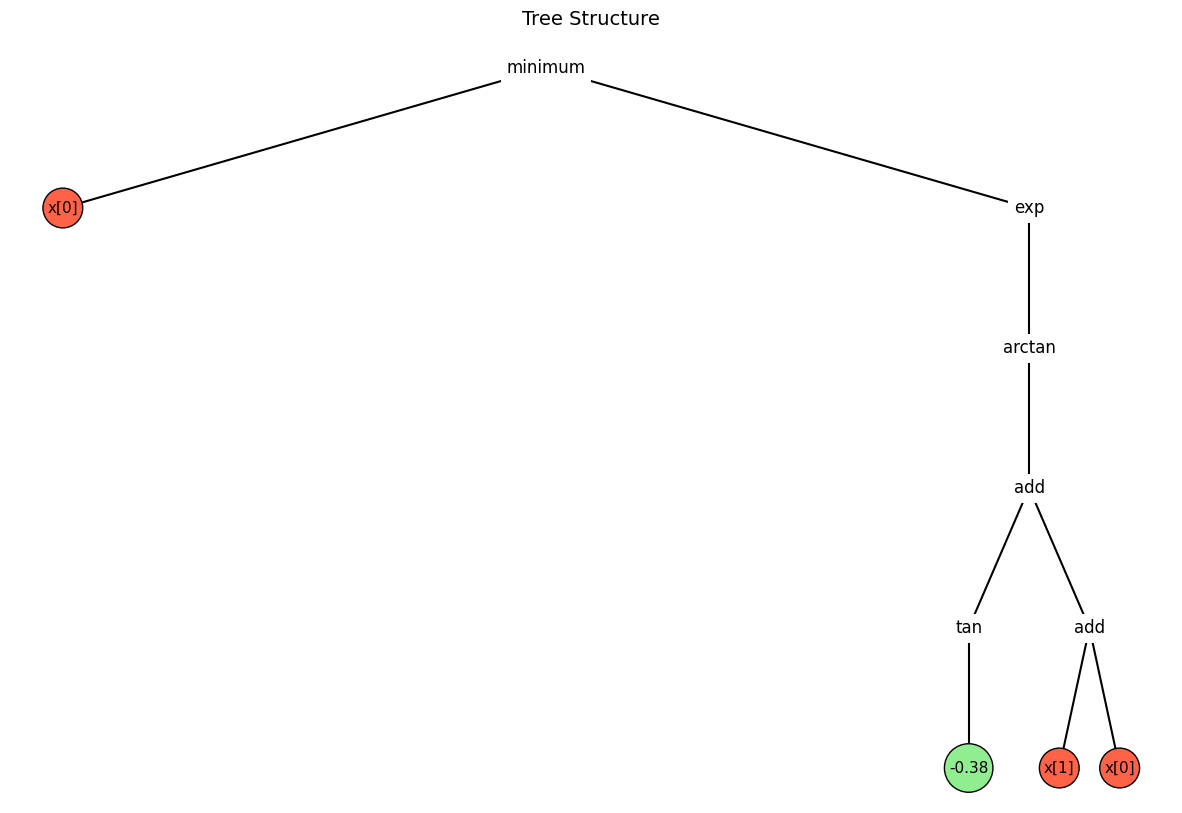

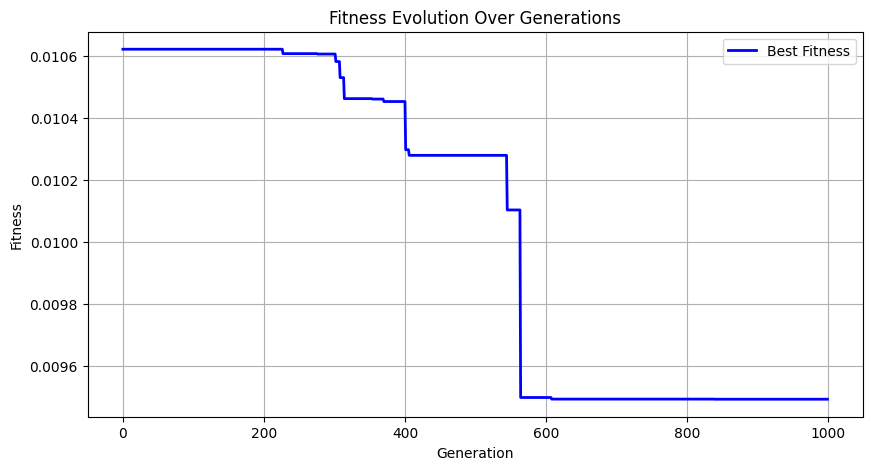

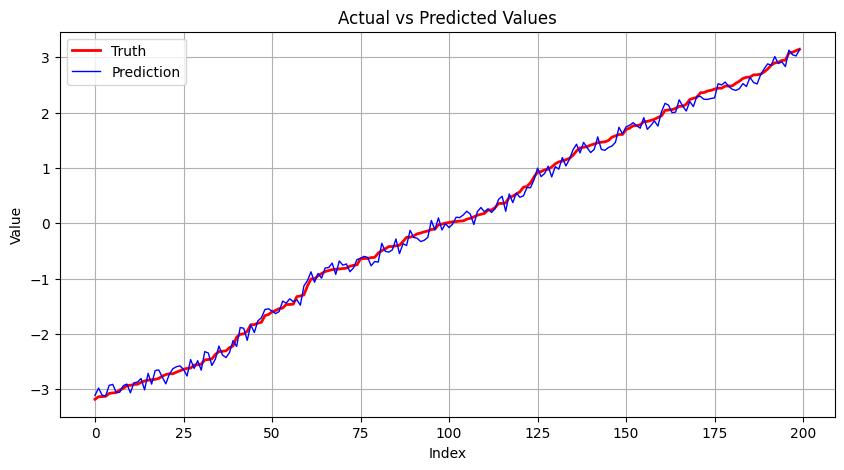

In [7]:
run_sym_reg_gp(0)

### Problem 1



Problem 1



Generations:  20%|██        | 204/1000 [00:10<00:36, 21.94it/s]

Generation 200:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations:  40%|████      | 404/1000 [00:21<00:27, 21.37it/s]

Generation 400:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations:  60%|██████    | 602/1000 [00:32<00:16, 23.43it/s]

Generation 600:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations:  80%|████████  | 805/1000 [00:41<00:08, 23.19it/s]

Generation 800:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])



Generations: 100%|██████████| 1000/1000 [00:50<00:00, 19.68it/s]

Generation 1000:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.sin(x[0])

Best global formula:  np.sin(x[0])
Best training fitness:  8.209276387950593e-34
Best testing fitness:  2.792598419361492e-34


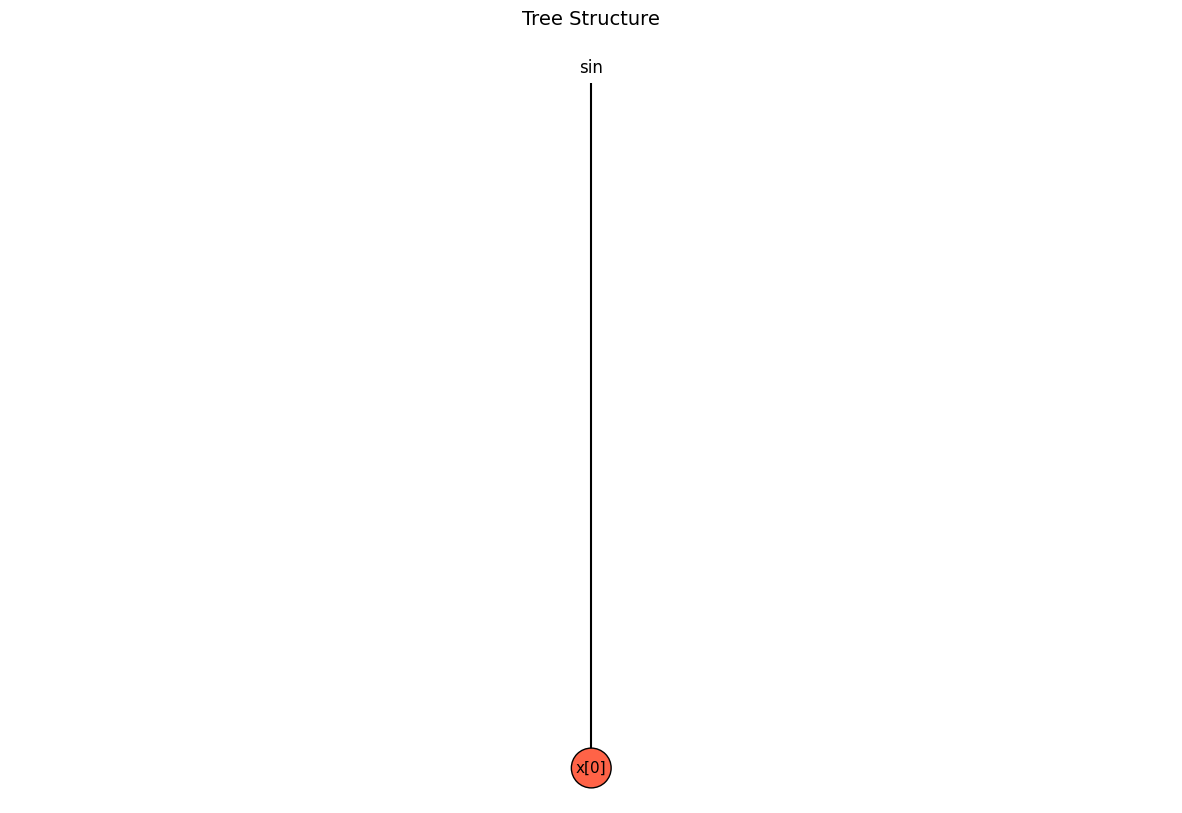

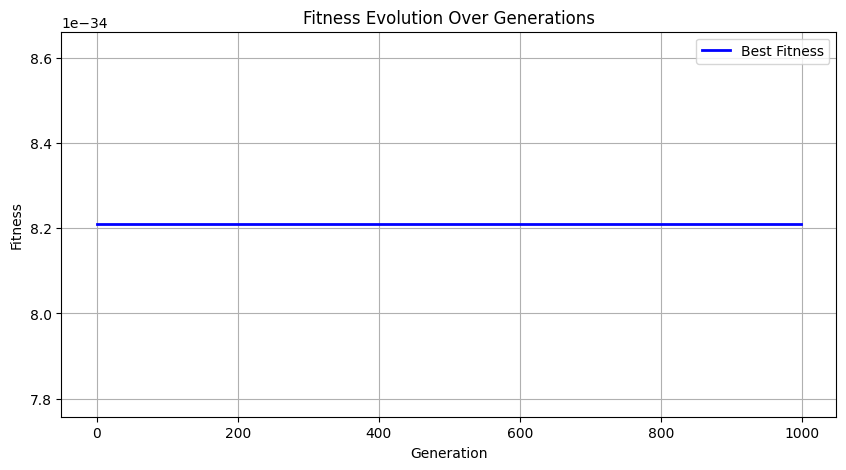

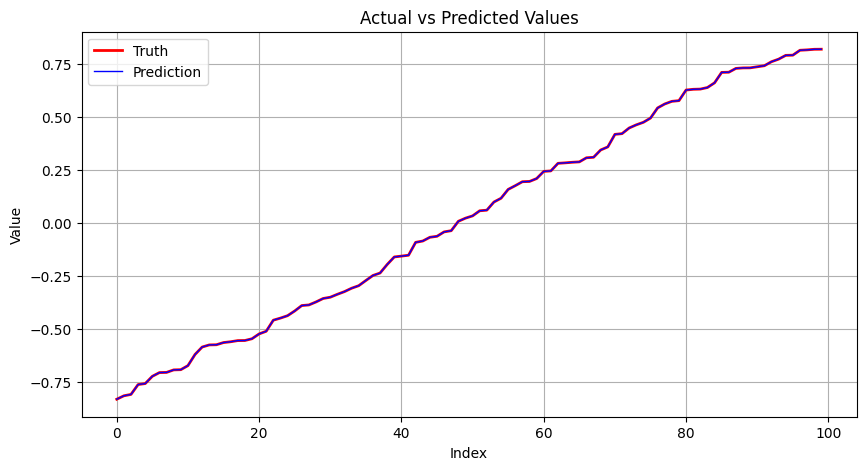

In [8]:
run_sym_reg_gp(1)

### Problem 2



Problem 2



Generations:  20%|██        | 201/1000 [00:27<01:32,  8.65it/s]

Generation 200:
    Island 1; Best fitness: 17694392336870.027344
    Island 2; Best fitness: 18823520210704.441406
    Island 3; Best fitness: 26724360991832.648438
    Island 4; Best fitness: 25446849185462.992188
    Island 5; Best fitness: 17400357011210.736328
    Best global fitness: 17400357011210.736328
    Best global formula: np.multiply(57516.15074512115, np.add(np.add(np.multiply(3.5112417742419506, x[0]), np.multiply(np.maximum(x[1], 5.439836790207407), np.add(x[2], x[1]))), np.add(np.multiply(3.5112417742419506, np.multiply(x[0], 3.6747934739846677)), np.multiply(5.06545222109262, np.maximum(x[0], -2.271897609725412)))))



Generations:  40%|████      | 402/1000 [00:51<01:04,  9.24it/s]

Generation 400:
    Island 1; Best fitness: 15743231572579.703125
    Island 2; Best fitness: 17208120192627.763672
    Island 3; Best fitness: 17585555090474.300781
    Island 4; Best fitness: 17585559608364.599609
    Island 5; Best fitness: 17375093851234.074219
    Best global fitness: 15743231572579.703125
    Best global formula: np.multiply(np.add(np.remainder(np.arcsin(np.tanh(x[0])), np.multiply(np.add(x[2], x[1]), 8.32253296422249)), np.add(np.multiply(3.5112417742419506, np.multiply(4.942605297679284, x[0])), np.multiply(8.32253296422249, np.maximum(x[0], -2.271897609725412)))), 57516.15074512115)



Generations:  60%|██████    | 600/1000 [01:41<01:49,  3.64it/s]

Generation 600:
    Island 1; Best fitness: 15622691518166.312500
    Island 2; Best fitness: 15647145396631.748047
    Island 3; Best fitness: 15648689816825.417969
    Island 4; Best fitness: 15072002107717.623047
    Island 5; Best fitness: 15647193839015.769531
    Best global fitness: 15072002107717.623047
    Best global formula: np.multiply(np.add(np.remainder(np.reciprocal(np.maximum(x[0], -0.14692720305684048)), np.multiply(np.add(x[2], x[1]), np.square(3.5190782194575867))), np.add(np.multiply(3.5112417742419506, np.multiply(4.88220203709847, x[0])), np.multiply(8.32253296422249, np.maximum(x[0], -2.271897609725412)))), 57516.15074512115)



Generations:  80%|████████  | 800/1000 [02:37<00:56,  3.57it/s]

Generation 800:
    Island 1; Best fitness: 14822882931136.244141
    Island 2; Best fitness: 15404610990445.523438
    Island 3; Best fitness: 15175579183014.509766
    Island 4; Best fitness: 15017397376907.998047
    Island 5; Best fitness: 14822882931136.244141
    Best global fitness: 14822882931136.244141
    Best global formula: np.multiply(np.add(np.remainder(np.reciprocal(np.remainder(-2.6330392629767005, x[0])), np.multiply(np.add(x[2], x[1]), np.multiply(-3.5633429495167004, -4.4649872511001165))), np.add(np.multiply(3.5193833787979703, np.multiply(4.78552815439779, x[0])), np.multiply(np.maximum(x[0], -2.365678938980861), 12.104175944265485))), 57516.15074512115)



Generations: 100%|██████████| 1000/1000 [03:37<00:00,  4.59it/s]

Generation 1000:
    Island 1; Best fitness: 14777243847749.343750
    Island 2; Best fitness: 14780288059558.183594
    Island 3; Best fitness: 14780288059558.183594
    Island 4; Best fitness: 14780288059558.183594
    Island 5; Best fitness: 14777243847749.343750
    Best global fitness: 14777243847749.343750
    Best global formula: np.multiply(57516.15074512115, np.add(np.remainder(np.reciprocal(np.remainder(2.7560121915927347, x[0])), np.multiply(np.add(x[2], x[1]), np.multiply(-3.5633429495167004, -4.232701977780494))), np.add(np.multiply(3.5193833787979703, np.multiply(4.78552815439779, x[0])), np.multiply(np.maximum(x[0], -2.392732440090854), 12.104175944265485))))

Best global formula:  np.multiply(57516.15074512115, np.add(np.remainder(np.reciprocal(np.remainder(2.7560121915927347, x[0])), np.multiply(np.add(x[2], x[1]), np.multiply(-3.5633429495167004, -4.232701977780494))), np.add(np.multiply(3.5193833787979703, np.multiply(4.78552815439779, x[0])), np.multiply(np.maximum(

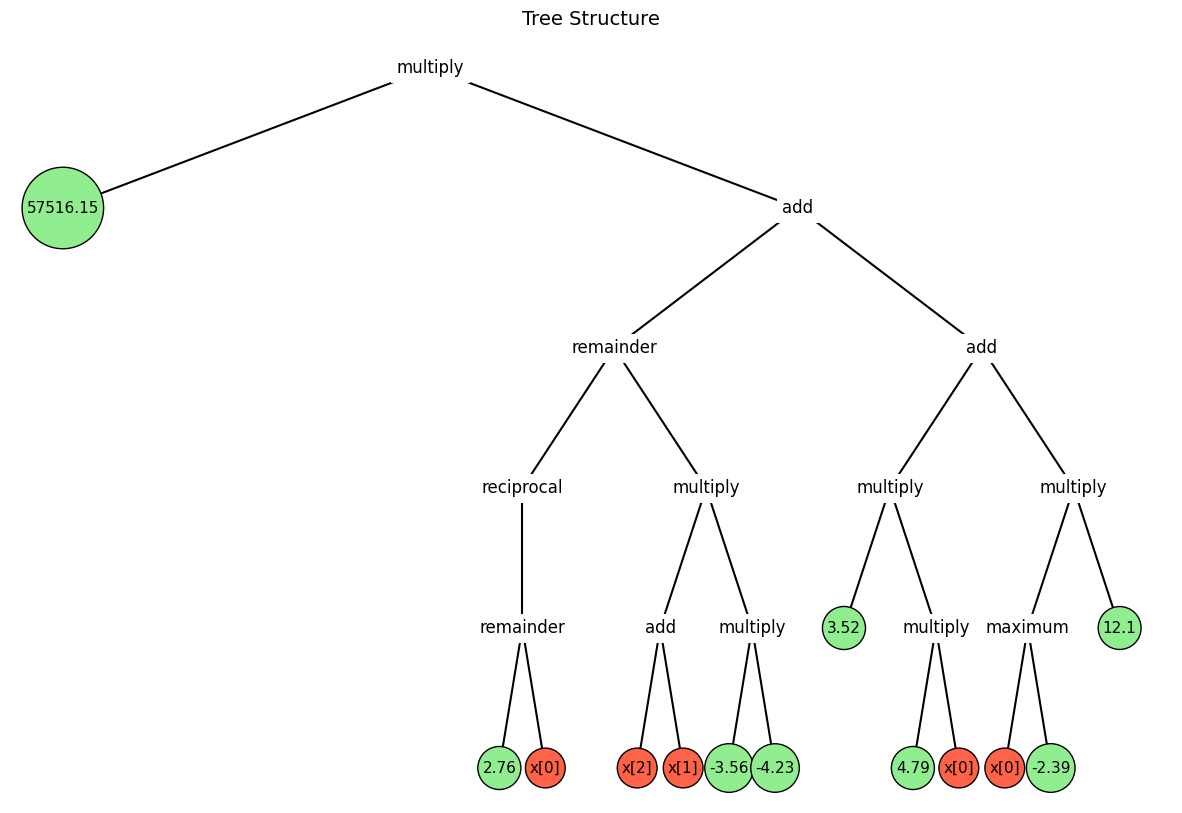

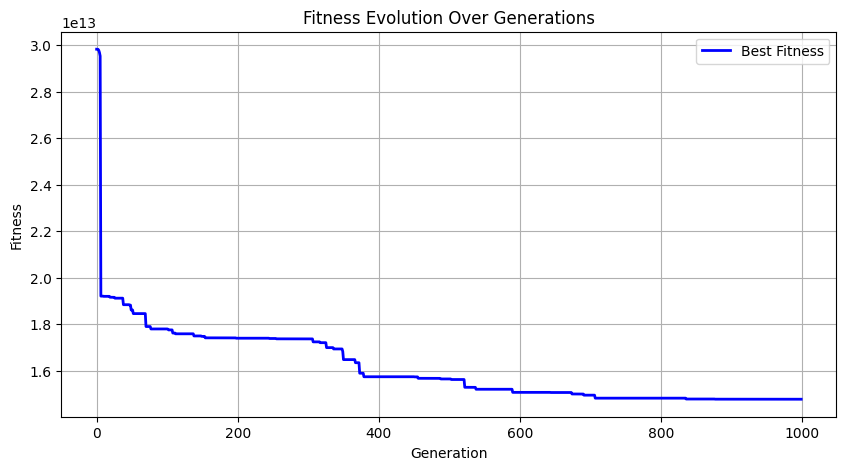

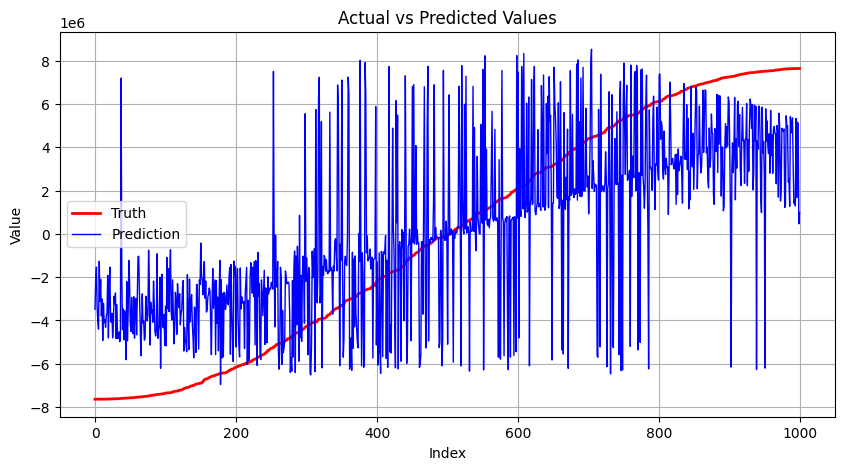

In [9]:
run_sym_reg_gp(2)

### Problem 3



Problem 3



Generations:  20%|██        | 200/1000 [00:59<03:37,  3.68it/s]

Generation 200:
    Island 1; Best fitness: 1067.820611
    Island 2; Best fitness: 350.831227
    Island 3; Best fitness: 1022.191548
    Island 4; Best fitness: 111.999630
    Island 5; Best fitness: 120.621977
    Best global fitness: 111.999630
    Best global formula: np.add(np.add(np.square(np.minimum(np.minimum(x[2], x[0]), np.subtract(-0.4513068098118671, x[0]))), np.sinh(np.negative(x[1]))), np.add(np.square(x[0]), np.sinh(np.negative(x[1]))))



Generations:  40%|████      | 400/1000 [02:02<03:12,  3.12it/s]

Generation 400:
    Island 1; Best fitness: 56.902637
    Island 2; Best fitness: 170.789299
    Island 3; Best fitness: 201.430329
    Island 4; Best fitness: 110.312524
    Island 5; Best fitness: 57.076926
    Best global fitness: 56.902637
    Best global formula: np.subtract(np.sinh(np.minimum(4.498375743170262, np.maximum(np.negative(x[0]), x[0]))), np.add(np.add(np.sinh(x[1]), np.sinh(x[1])), np.minimum(np.add(np.square(x[2]), -4.309536770967134), np.add(np.add(x[2], x[2]), np.add(x[2], -5.636150907201751)))))



Generations:  60%|██████    | 601/1000 [02:58<00:58,  6.87it/s]

Generation 600:
    Island 1; Best fitness: 55.013452
    Island 2; Best fitness: 55.322078
    Island 3; Best fitness: 55.486399
    Island 4; Best fitness: 47.567477
    Island 5; Best fitness: 53.395066
    Best global fitness: 47.567477
    Best global formula: np.subtract(np.sinh(np.minimum(4.498375743170262, np.maximum(np.negative(x[0]), x[0]))), np.add(np.add(np.sinh(np.minimum(4.616398953942235, x[1])), np.sinh(x[1])), np.minimum(np.add(np.square(x[2]), np.add(x[0], x[1])), np.add(np.add(x[2], x[2]), np.add(x[2], -5.636150907201751)))))



Generations:  80%|████████  | 800/1000 [03:31<00:38,  5.16it/s]

Generation 800:
    Island 1; Best fitness: 44.611151
    Island 2; Best fitness: 54.656072
    Island 3; Best fitness: 51.706461
    Island 4; Best fitness: 45.610910
    Island 5; Best fitness: 43.990400
    Best global fitness: 43.990400
    Best global formula: np.subtract(np.sinh(np.minimum(4.447919012715498, np.maximum(np.negative(x[0]), x[0]))), np.add(np.add(np.sinh(np.minimum(4.616398953942235, x[1])), np.sinh(x[1])), np.minimum(np.multiply(5.379728240795753, x[2]), np.add(np.add(x[2], x[1]), np.add(x[2], -4.723215547092456)))))



Generations: 100%|██████████| 1000/1000 [03:59<00:00,  4.18it/s]

Generation 1000:
    Island 1; Best fitness: 43.007414
    Island 2; Best fitness: 43.007414
    Island 3; Best fitness: 43.007414
    Island 4; Best fitness: 43.007414
    Island 5; Best fitness: 43.007414
    Best global fitness: 43.007414
    Best global formula: np.subtract(np.sinh(np.minimum(4.447919012715498, np.maximum(np.negative(x[0]), x[0]))), np.add(np.add(np.sinh(np.minimum(4.480363382671386, x[1])), np.sinh(x[1])), np.minimum(np.multiply(np.maximum(-0.6960596060083484, 5.51408030712835), x[2]), np.add(np.add(x[2], x[2]), np.add(x[1], -4.170486475361723)))))

Best global formula:  np.subtract(np.sinh(np.minimum(4.447919012715498, np.maximum(np.negative(x[0]), x[0]))), np.add(np.add(np.sinh(np.minimum(4.480363382671386, x[1])), np.sinh(x[1])), np.minimum(np.multiply(np.maximum(-0.6960596060083484, 5.51408030712835), x[2]), np.add(np.add(x[2], x[2]), np.add(x[1], -4.170486475361723)))))
Best training fitness:  43.00741446888247
Best testing fitness:  40.733928259737255


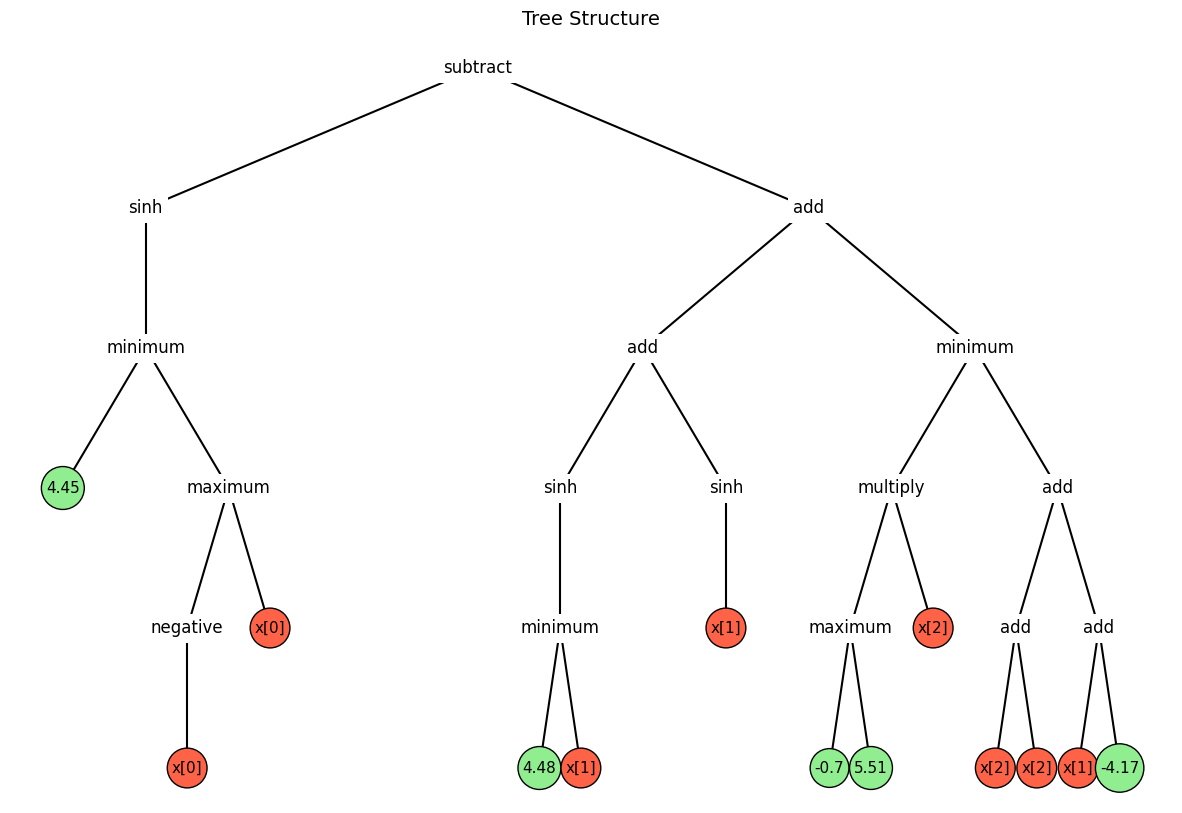

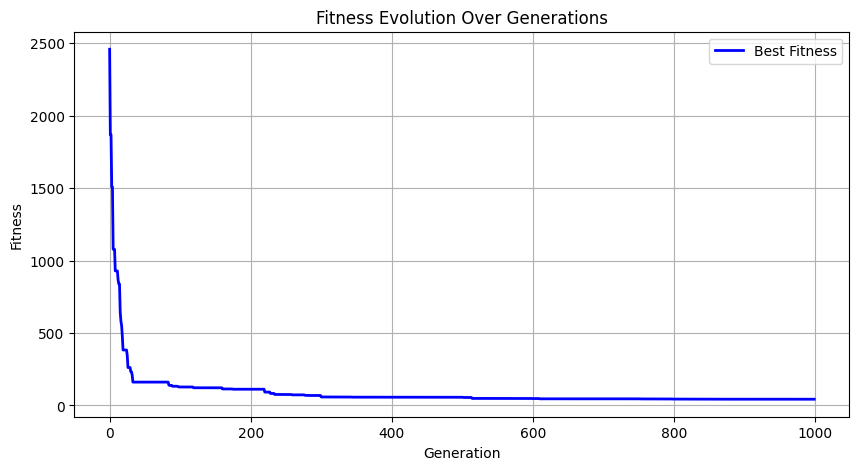

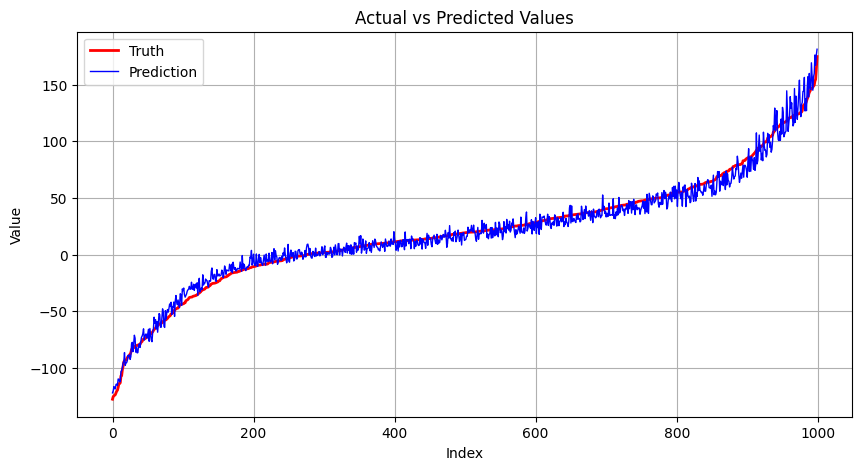

In [10]:
run_sym_reg_gp(3)

### Problem 4



Problem 4



Generations:  20%|██        | 200/1000 [00:24<01:09, 11.43it/s]

Generation 200:
    Island 1; Best fitness: 6.490255
    Island 2; Best fitness: 10.130535
    Island 3; Best fitness: 0.071969
    Island 4; Best fitness: 3.663232
    Island 5; Best fitness: 8.405388
    Best global fitness: 0.071969
    Best global formula: np.divide(6.916581339526834, np.reciprocal(np.subtract(np.cos(x[1]), -0.47539540719157625)))



Generations:  40%|████      | 402/1000 [00:43<01:00,  9.96it/s]

Generation 400:
    Island 1; Best fitness: 0.071969
    Island 2; Best fitness: 5.782005
    Island 3; Best fitness: 0.071910
    Island 4; Best fitness: 0.071969
    Island 5; Best fitness: 0.071969
    Best global fitness: 0.071910
    Best global formula: np.divide(6.916581339526834, np.reciprocal(np.subtract(np.cos(x[1]), -0.4686242491882533)))



Generations:  60%|██████    | 602/1000 [01:02<00:37, 10.74it/s]

Generation 600:
    Island 1; Best fitness: 0.071910
    Island 2; Best fitness: 0.071969
    Island 3; Best fitness: 0.071910
    Island 4; Best fitness: 0.071910
    Island 5; Best fitness: 0.071910
    Best global fitness: 0.071910
    Best global formula: np.divide(6.916581339526834, np.reciprocal(np.subtract(np.cos(x[1]), -0.4686242491882533)))



Generations:  80%|████████  | 801/1000 [01:25<00:22,  8.72it/s]

Generation 800:
    Island 1; Best fitness: 0.071910
    Island 2; Best fitness: 0.071910
    Island 3; Best fitness: 0.071910
    Island 4; Best fitness: 0.071910
    Island 5; Best fitness: 0.071910
    Best global fitness: 0.071910
    Best global formula: np.divide(6.916581339526834, np.reciprocal(np.subtract(np.cos(x[1]), -0.4686242491882533)))



Generations: 100%|██████████| 1000/1000 [01:49<00:00,  9.15it/s]

Generation 1000:
    Island 1; Best fitness: 0.071910
    Island 2; Best fitness: 0.071910
    Island 3; Best fitness: 0.071910
    Island 4; Best fitness: 0.071910
    Island 5; Best fitness: 0.071910
    Best global fitness: 0.071910
    Best global formula: np.divide(6.916581339526834, np.reciprocal(np.subtract(np.cos(x[1]), -0.4686242491882533)))

Best global formula:  np.divide(6.916581339526834, np.reciprocal(np.subtract(np.cos(x[1]), -0.4686242491882533)))
Best training fitness:  0.07190968522798531
Best testing fitness:  0.07129755243093974


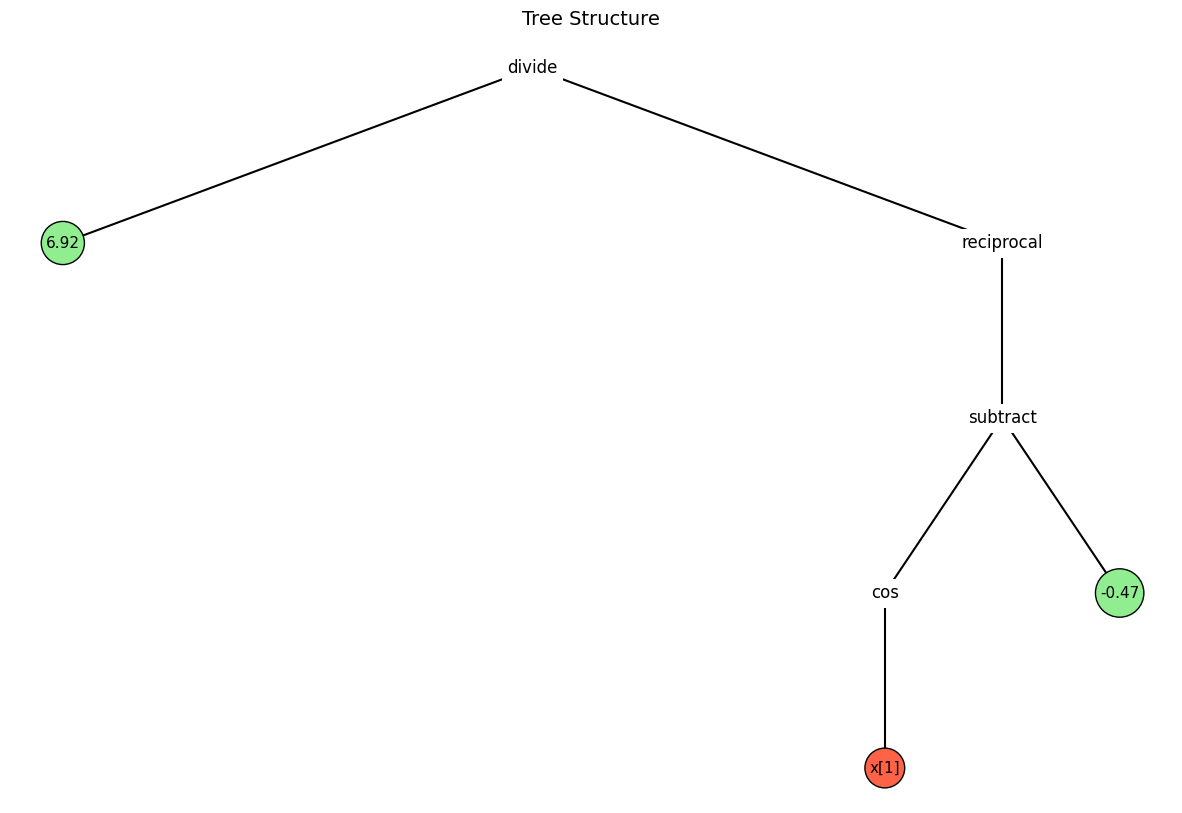

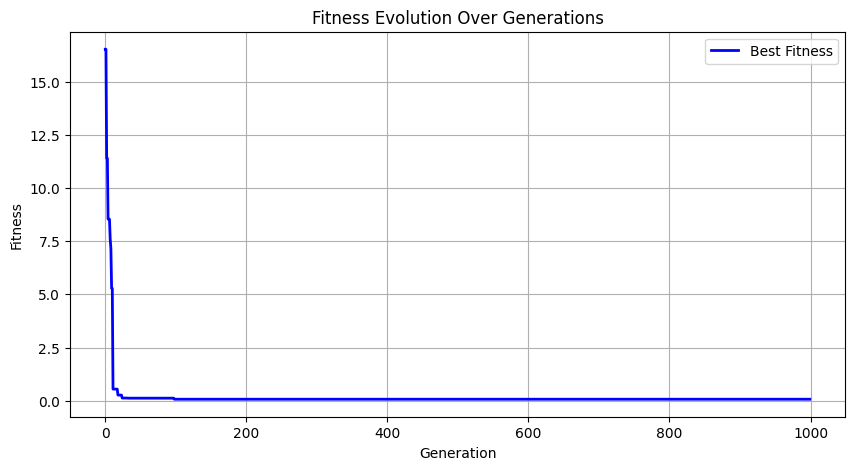

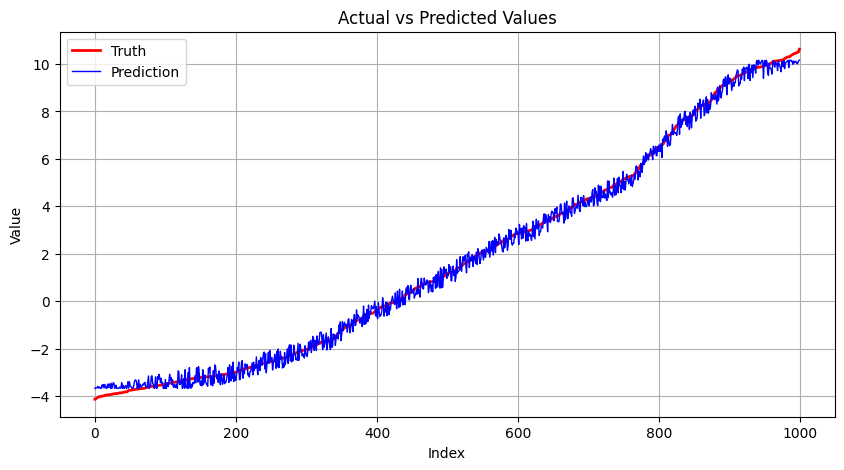

In [11]:
run_sym_reg_gp(4)

### Problem 5



Problem 5



Generations:  20%|██        | 200/1000 [00:28<01:42,  7.84it/s]

Generation 200:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.negative(np.power(np.tanh(np.tanh(0.12320940940031547)), 10.110422635863348))



Generations:  40%|████      | 402/1000 [00:49<00:49, 12.18it/s]

Generation 400:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.negative(np.power(np.tanh(np.divide(np.remainder(x[0], x[1]), np.exp(3.2750658564923696))), 10.110422635863348))



Generations:  60%|██████    | 600/1000 [01:08<00:39, 10.18it/s]

Generation 600:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.negative(np.power(np.tanh(np.divide(np.minimum(x[1], x[0]), np.exp(3.2966067061244595))), 10.110422635863348))



Generations:  80%|████████  | 801/1000 [01:27<00:18, 10.76it/s]

Generation 800:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.negative(np.power(np.tanh(np.divide(np.minimum(x[1], x[0]), np.exp(3.2966067061244595))), 10.110422635863348))



Generations: 100%|██████████| 1000/1000 [01:47<00:00,  9.26it/s]


Generation 1000:
    Island 1; Best fitness: 0.000000
    Island 2; Best fitness: 0.000000
    Island 3; Best fitness: 0.000000
    Island 4; Best fitness: 0.000000
    Island 5; Best fitness: 0.000000
    Best global fitness: 0.000000
    Best global formula: np.negative(np.power(np.tanh(np.divide(np.minimum(x[1], x[0]), np.exp(3.2966067061244595))), 10.110422635863348))

Best global formula:  np.negative(np.power(np.tanh(np.divide(np.minimum(x[1], x[0]), np.exp(3.2966067061244595))), 10.110422635863348))
Best training fitness:  4.936141239341651e-19
Best testing fitness:  5.008710981364801e-19


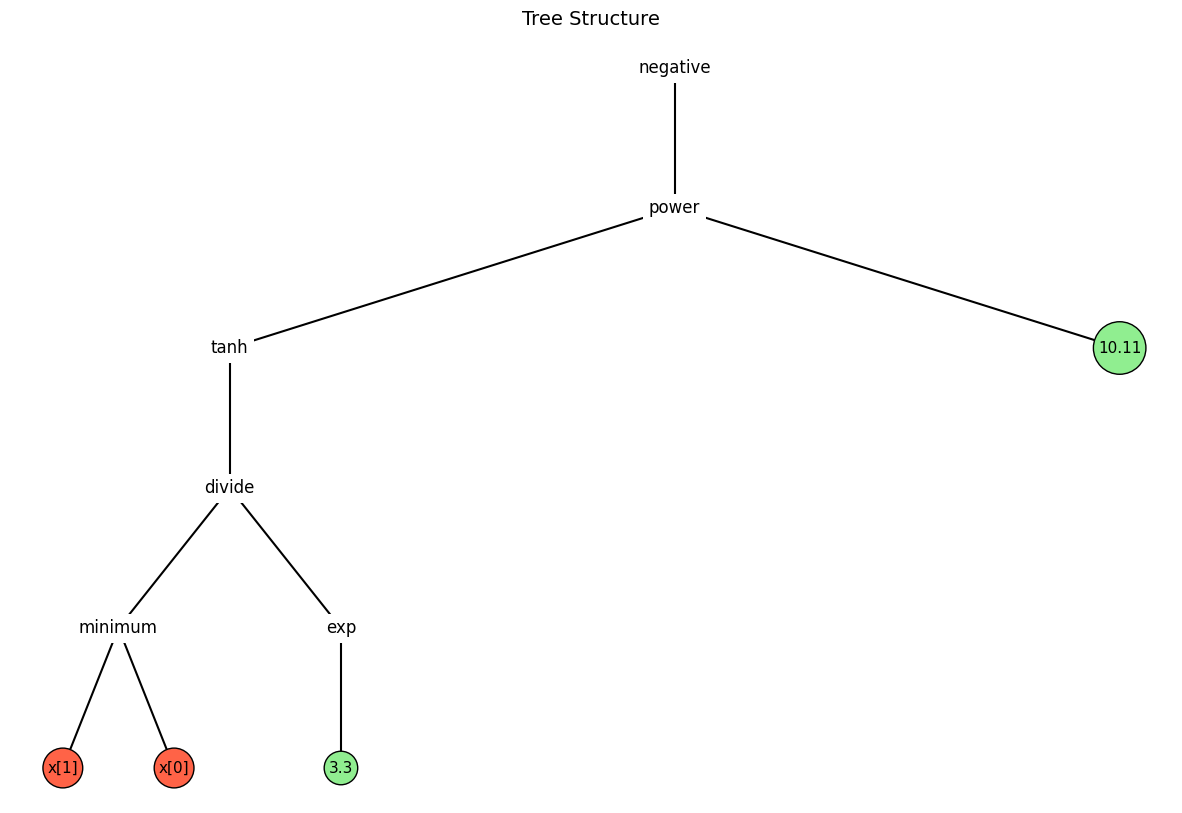

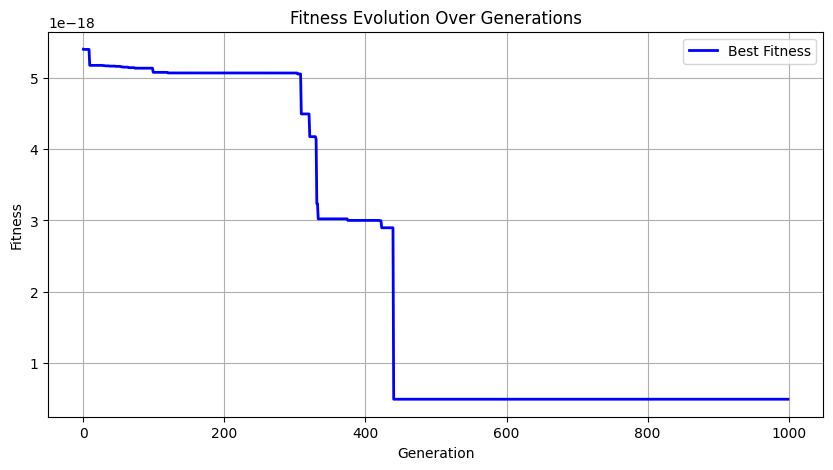

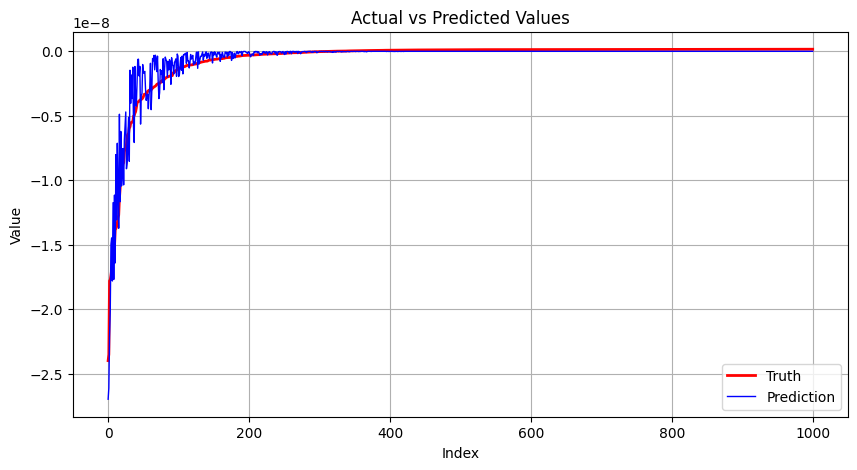

In [12]:
run_sym_reg_gp(5)

### Problem 6



Problem 6



Generations:  20%|██        | 200/1000 [00:29<01:53,  7.05it/s]

Generation 200:
    Island 1; Best fitness: 0.258849
    Island 2; Best fitness: 0.292571
    Island 3; Best fitness: 0.252708
    Island 4; Best fitness: 0.093258
    Island 5; Best fitness: 0.000879
    Best global fitness: 0.000879
    Best global formula: np.subtract(x[1], np.multiply(np.subtract(x[1], np.maximum(x[0], np.negative(4.617042706200519))), -0.6873577014794435))



Generations:  40%|████      | 401/1000 [00:57<01:17,  7.77it/s]

Generation 400:
    Island 1; Best fitness: 0.000879
    Island 2; Best fitness: 0.177345
    Island 3; Best fitness: 0.110338
    Island 4; Best fitness: 0.069045
    Island 5; Best fitness: 0.000879
    Best global fitness: 0.000879
    Best global formula: np.subtract(x[1], np.multiply(np.subtract(x[1], np.maximum(x[0], np.negative(4.617042706200519))), -0.6873577014794435))



Generations:  60%|██████    | 600/1000 [01:18<00:29, 13.76it/s]

Generation 600:
    Island 1; Best fitness: 0.000879
    Island 2; Best fitness: 0.000879
    Island 3; Best fitness: 0.000879
    Island 4; Best fitness: 0.000879
    Island 5; Best fitness: 0.000662
    Best global fitness: 0.000662
    Best global formula: np.subtract(x[1], np.multiply(np.subtract(x[1], np.maximum(np.subtract(x[0], -0.008498429686738973), x[0])), -0.6873577014794435))



Generations:  80%|████████  | 802/1000 [01:34<00:18, 10.76it/s]

Generation 800:
    Island 1; Best fitness: 0.000518
    Island 2; Best fitness: 0.000879
    Island 3; Best fitness: 0.000879
    Island 4; Best fitness: 0.000879
    Island 5; Best fitness: 0.000518
    Best global fitness: 0.000518
    Best global formula: np.subtract(x[1], np.multiply(np.subtract(np.reciprocal(np.reciprocal(x[1])), np.maximum(np.subtract(x[0], -0.04610901641572074), x[0])), -0.6873577014794435))



Generations: 100%|██████████| 1000/1000 [01:52<00:00,  8.89it/s]


Generation 1000:
    Island 1; Best fitness: 0.000480
    Island 2; Best fitness: 0.000480
    Island 3; Best fitness: 0.000480
    Island 4; Best fitness: 0.000480
    Island 5; Best fitness: 0.000480
    Best global fitness: 0.000480
    Best global formula: np.subtract(x[1], np.multiply(np.subtract(x[1], np.maximum(np.subtract(x[0], -0.04610901641572074), x[0])), np.reciprocal(np.multiply(-1.0607763990908596, np.arctan(4.896040515230957)))))

Best global formula:  np.subtract(x[1], np.multiply(np.subtract(x[1], np.maximum(np.subtract(x[0], -0.04610901641572074), x[0])), np.reciprocal(np.multiply(-1.0607763990908596, np.arctan(4.896040515230957)))))
Best training fitness:  0.0004796819357558786
Best testing fitness:  0.00047354506776559486


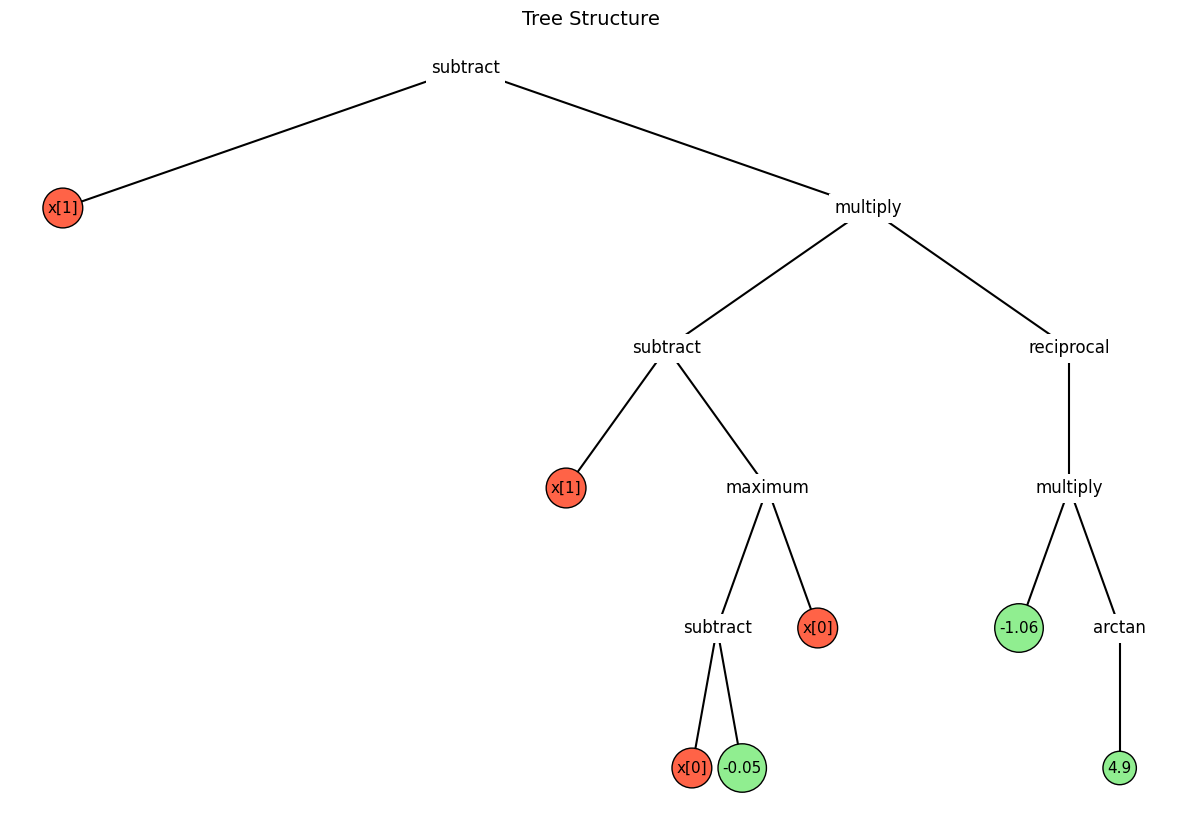

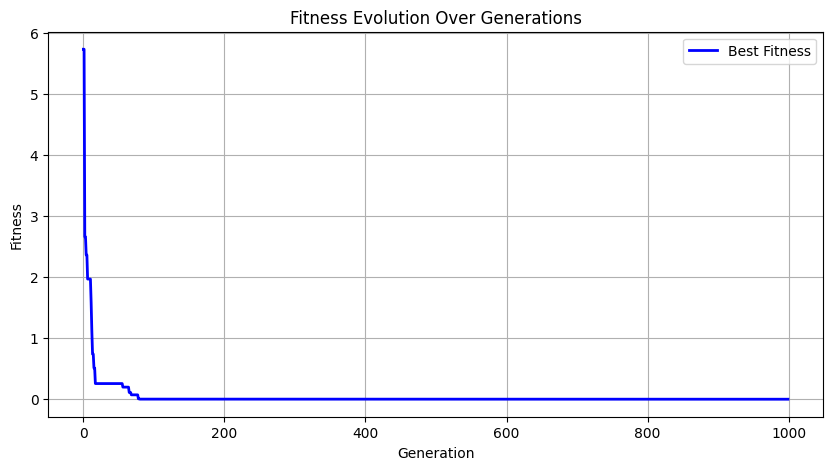

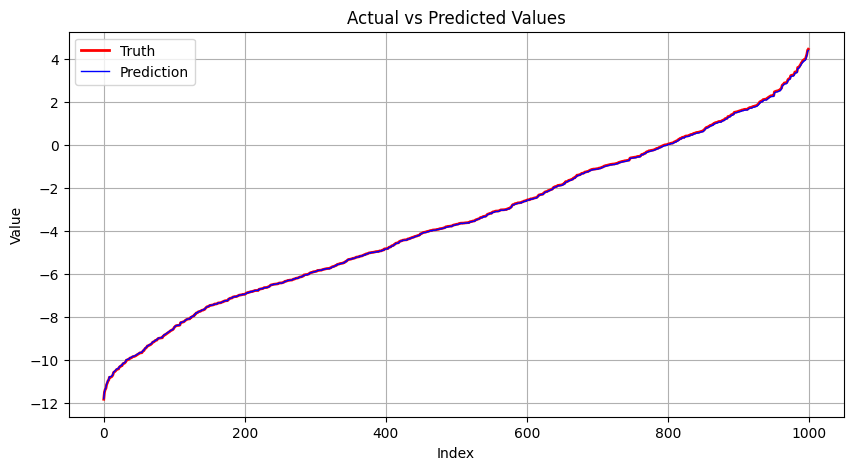

In [13]:
run_sym_reg_gp(6)

### Problem 7



Problem 7



Generations:  20%|██        | 201/1000 [00:39<02:10,  6.12it/s]

Generation 200:
    Island 1; Best fitness: 335.651370
    Island 2; Best fitness: 327.516737
    Island 3; Best fitness: 344.032544
    Island 4; Best fitness: 312.227356
    Island 5; Best fitness: 544.293764
    Best global fitness: 312.227356
    Best global formula: np.add(np.power(np.sinh(np.multiply(-1.696378124442417, -1.696378124442417)), np.minimum(np.multiply(x[1], np.reciprocal(x[0])), np.power(np.divide(x[0], x[0]), np.multiply(x[1], -0.38181976418899355)))), np.power(np.power(np.multiply(np.arcsin(-0.9184477422076378), -1.696378124442417), np.multiply(2.1790601396456895, np.maximum(x[1], -1.7735275894400593))), x[0]))



Generations:  40%|████      | 401/1000 [01:19<02:03,  4.86it/s]

Generation 400:
    Island 1; Best fitness: 293.080989
    Island 2; Best fitness: 312.299185
    Island 3; Best fitness: 320.057029
    Island 4; Best fitness: 311.879175
    Island 5; Best fitness: 271.690311
    Best global fitness: 271.690311
    Best global formula: np.add(np.power(np.sinh(3.4061745936735583), np.minimum(np.multiply(x[1], np.reciprocal(x[0])), np.tanh(np.cosh(x[0])))), np.power(np.power(np.multiply(np.arcsin(-0.9184477422076378), -1.696378124442417), np.multiply(2.2288087755462564, np.maximum(x[1], -1.7735275894400593))), np.minimum(np.maximum(1.4379900064157454, x[1]), np.maximum(x[0], -1.696378124442417))))



Generations:  60%|██████    | 600/1000 [02:02<01:31,  4.35it/s]

Generation 600:
    Island 1; Best fitness: 258.116057
    Island 2; Best fitness: 281.405347
    Island 3; Best fitness: 291.374225
    Island 4; Best fitness: 289.830357
    Island 5; Best fitness: 270.733917
    Best global fitness: 258.116057
    Best global formula: np.add(np.power(28.21113475146538, np.minimum(np.multiply(x[1], np.reciprocal(x[0])), np.absolute(np.arctan(x[0])))), np.power(np.power(np.multiply(np.arcsin(-0.9184477422076378), -1.696378124442417), np.multiply(2.1790601396456895, np.maximum(-1.7510181552672508, x[1]))), np.minimum(np.maximum(-0.34982906411792625, x[1]), np.maximum(x[0], -1.696378124442417))))



Generations:  80%|████████  | 801/1000 [02:47<00:44,  4.44it/s]

Generation 800:
    Island 1; Best fitness: 194.540524
    Island 2; Best fitness: 218.387841
    Island 3; Best fitness: 218.387841
    Island 4; Best fitness: 197.847778
    Island 5; Best fitness: 207.760351
    Best global fitness: 194.540524
    Best global formula: np.add(np.power(np.exp(np.square(1.9748183245131932)), np.minimum(np.multiply(np.reciprocal(x[0]), x[1]), np.absolute(np.divide(x[0], x[1])))), np.power(np.power(1.9748183245131932, np.multiply(np.minimum(2.1939872148505275, 2.2487268736354933), np.maximum(-1.7510181552672508, x[1]))), np.minimum(np.maximum(-0.34982906411792625, x[1]), np.maximum(x[0], -1.7451879320706367))))



Generations: 100%|██████████| 1000/1000 [03:38<00:00,  4.58it/s]

Generation 1000:
    Island 1; Best fitness: 167.268959
    Island 2; Best fitness: 167.268959
    Island 3; Best fitness: 167.268959
    Island 4; Best fitness: 167.268959
    Island 5; Best fitness: 167.268959
    Best global fitness: 167.268959
    Best global formula: np.add(np.power(np.exp(np.square(np.negative(-2.0268642087111344))), np.minimum(np.multiply(np.reciprocal(x[0]), x[1]), np.square(np.divide(x[0], x[1])))), np.power(np.power(np.absolute(1.9785012927742578), np.multiply(np.minimum(2.1939872148505275, 2.142851324455444), np.maximum(-1.7510181552672508, x[1]))), np.minimum(np.maximum(-0.34982906411792625, x[1]), np.maximum(x[0], -1.7451879320706367))))

Best global formula:  np.add(np.power(np.exp(np.square(np.negative(-2.0268642087111344))), np.minimum(np.multiply(np.reciprocal(x[0]), x[1]), np.square(np.divide(x[0], x[1])))), np.power(np.power(np.absolute(1.9785012927742578), np.multiply(np.minimum(2.1939872148505275, 2.142851324455444), np.maximum(-1.7510181552672508,

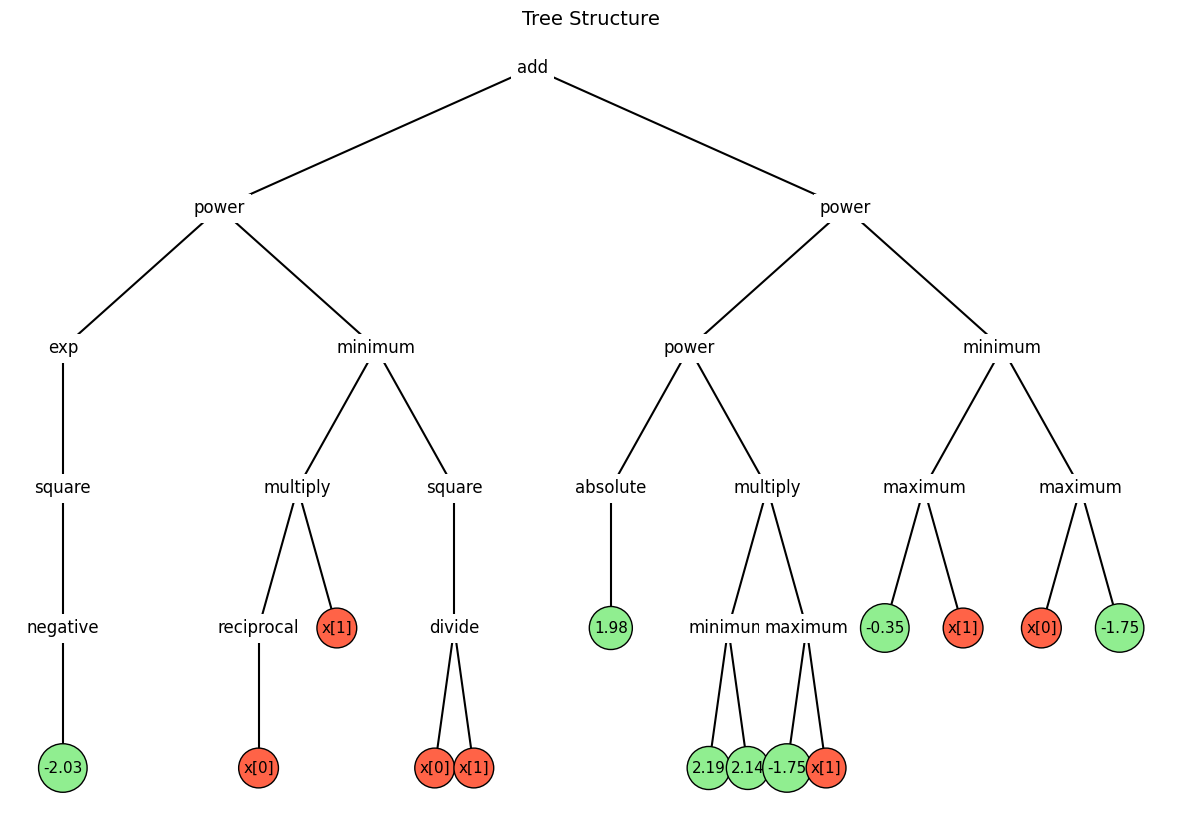

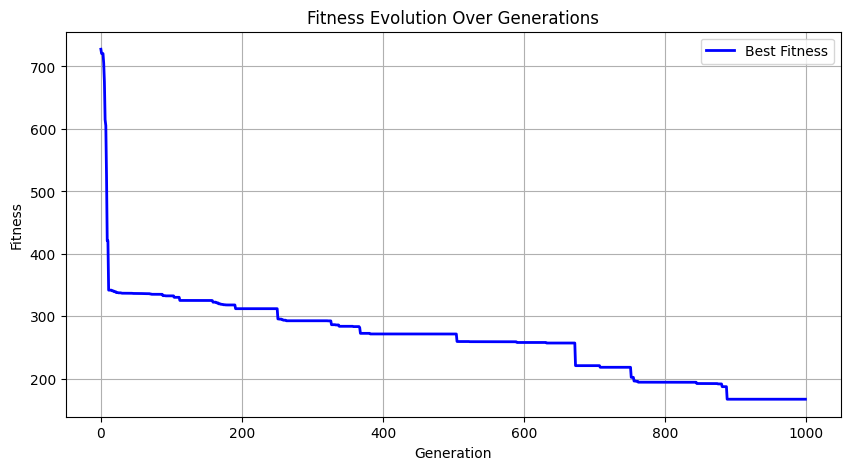

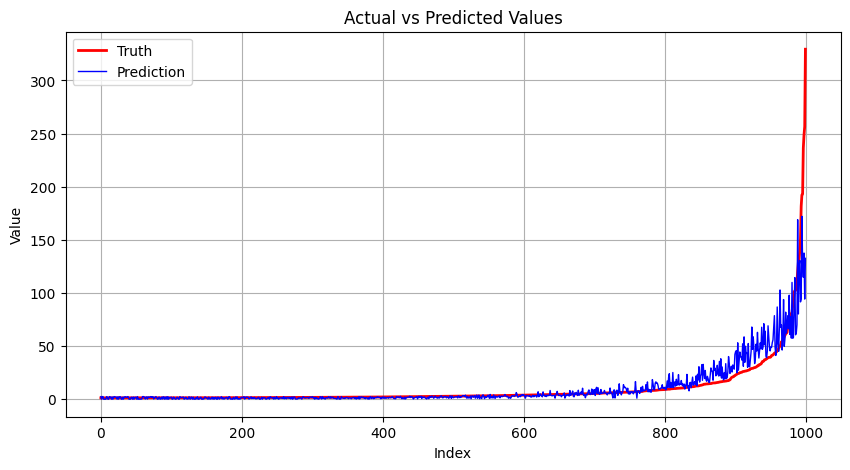

In [14]:
run_sym_reg_gp(7)

### Problem 8



Problem 8



Generations:  20%|██        | 200/1000 [03:15<11:29,  1.16it/s]

Generation 200:
    Island 1; Best fitness: 6651756.699134
    Island 2; Best fitness: 1460927.132898
    Island 3; Best fitness: 6651756.699134
    Island 4; Best fitness: 2634361.489375
    Island 5; Best fitness: 412349.453839
    Best global fitness: 412349.453839
    Best global formula: np.multiply(np.add(np.divide(np.cosh(5.053439783532889), np.minimum(48.54840127376508, 5.053439783532889)), 48.54840127376508), np.add(np.multiply(np.subtract(np.add(4.311481877742289, 2.494505917579821), np.subtract(-0.3985782809284828, -3.600165928465604)), np.sinh(x[5])), np.add(np.minimum(np.maximum(-5.038730967687038, x[4]), np.subtract(x[3], x[4])), np.add(np.multiply(x[5], -3.8949473739121965), -4.4863634392895095))))



Generations:  40%|████      | 400/1000 [06:36<08:40,  1.15it/s]

Generation 400:
    Island 1; Best fitness: 97602.610835
    Island 2; Best fitness: 1109522.963255
    Island 3; Best fitness: 1267964.378133
    Island 4; Best fitness: 1286092.027825
    Island 5; Best fitness: 96351.151551
    Best global fitness: 96351.151551
    Best global formula: np.multiply(np.add(15.49107797050281, 48.54840127376508), np.add(np.multiply(np.subtract(np.add(2.494505917579821, 4.311481877742289), np.add(-0.11271476993519425, 3.213184515982914)), np.sinh(x[5])), np.add(np.multiply(np.maximum(-5.038730967687038, x[4]), np.subtract(-0.11627537709785596, x[4])), np.add(np.multiply(x[5], -5.032969390167829), np.log10(0.7698537804669785)))))



Generations:  60%|██████    | 600/1000 [09:10<04:33,  1.46it/s]

Generation 600:
    Island 1; Best fitness: 75380.353229
    Island 2; Best fitness: 80918.666534
    Island 3; Best fitness: 83131.773992
    Island 4; Best fitness: 82540.897043
    Island 5; Best fitness: 74170.573675
    Best global fitness: 74170.573675
    Best global formula: np.multiply(np.cosh(4.8605821220683625), np.add(np.multiply(np.subtract(np.add(2.494505917579821, 4.311481877742289), np.add(-0.11271476993519425, 3.213184515982914)), np.sinh(x[5])), np.add(np.multiply(np.maximum(-5.038730967687038, x[4]), np.subtract(-0.0016875693462798935, x[4])), np.add(np.multiply(x[5], -5.745610442166889), x[3]))))



Generations:  80%|████████  | 800/1000 [12:12<01:50,  1.81it/s]

Generation 800:
    Island 1; Best fitness: 74011.564915
    Island 2; Best fitness: 75196.819175
    Island 3; Best fitness: 74820.232623
    Island 4; Best fitness: 75196.819175
    Island 5; Best fitness: 74011.564915
    Best global fitness: 74011.564915
    Best global formula: np.multiply(np.cosh(4.8605821220683625), np.add(np.add(np.multiply(np.maximum(-5.038730967687038, x[4]), np.subtract(-0.00580726799718434, x[4])), np.add(np.multiply(x[5], -5.71870513433915), x[3])), np.multiply(np.subtract(np.add(2.494505917579821, 4.311481877742289), np.add(-0.11271476993519425, 3.213184515982914)), np.sinh(x[5]))))



Generations: 100%|██████████| 1000/1000 [17:02<00:00,  1.02s/it]

Generation 1000:
    Island 1; Best fitness: 73838.526220
    Island 2; Best fitness: 73838.526220
    Island 3; Best fitness: 73838.526220
    Island 4; Best fitness: 73838.526220
    Island 5; Best fitness: 73838.526220
    Best global fitness: 73838.526220
    Best global formula: np.multiply(np.cosh(4.8605821220683625), np.add(np.add(np.multiply(np.maximum(-5.038730967687038, x[4]), np.subtract(-0.00580726799718434, x[4])), np.add(np.multiply(x[5], -5.65068901255147), x[3])), np.multiply(np.subtract(np.add(2.494505917579821, 4.311481877742289), np.add(-0.11271476993519425, 3.213184515982914)), np.sinh(x[5]))))

Best global formula:  np.multiply(np.cosh(4.8605821220683625), np.add(np.add(np.multiply(np.maximum(-5.038730967687038, x[4]), np.subtract(-0.00580726799718434, x[4])), np.add(np.multiply(x[5], -5.65068901255147), x[3])), np.multiply(np.subtract(np.add(2.494505917579821, 4.311481877742289), np.add(-0.11271476993519425, 3.213184515982914)), np.sinh(x[5]))))
Best training fitn

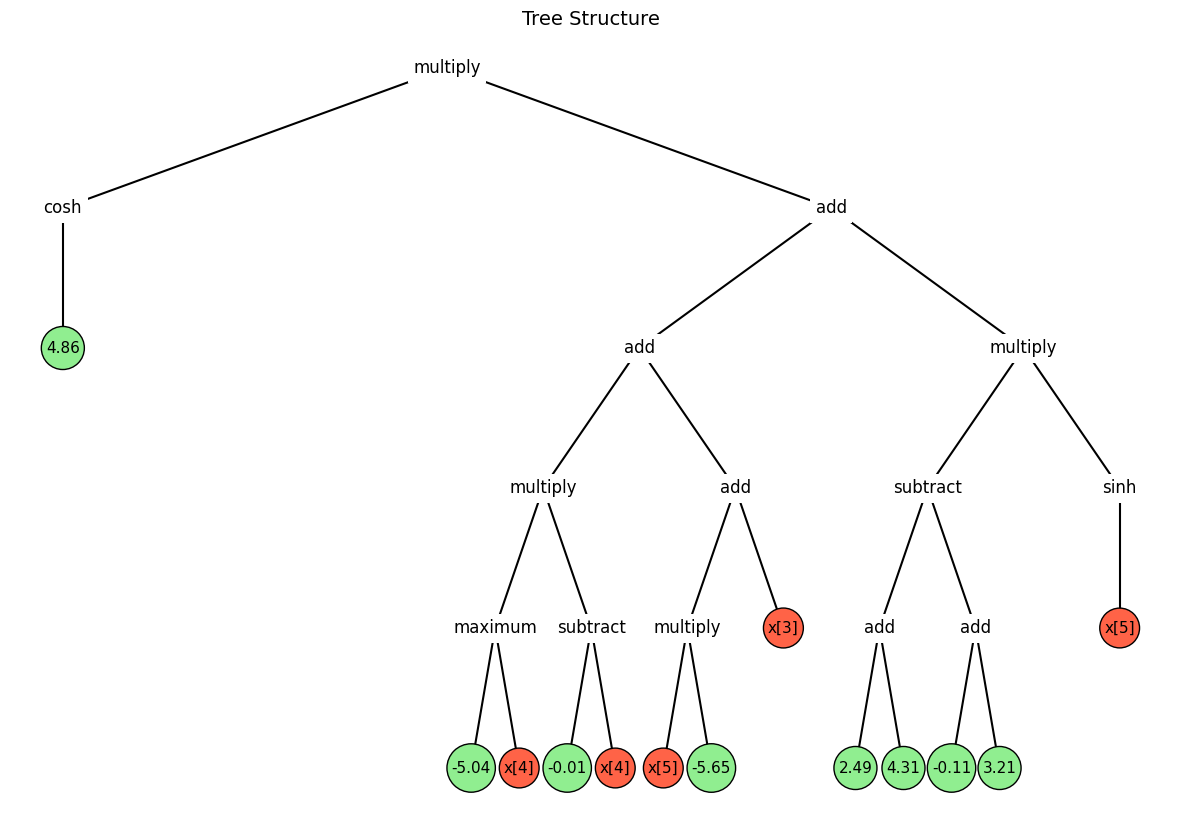

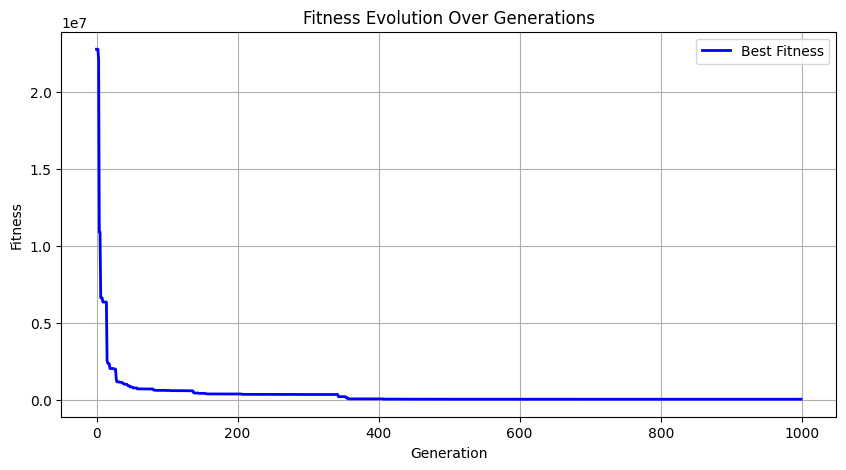

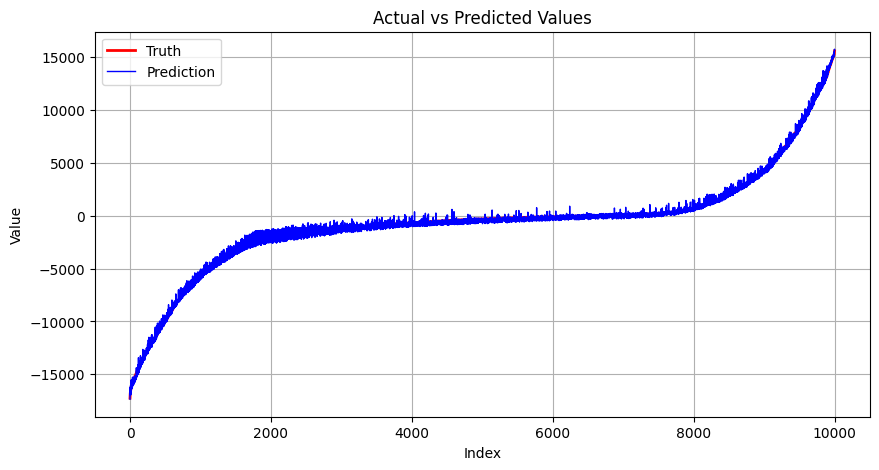

In [15]:
run_sym_reg_gp(8)